## Time Series of Vegetation Phenology using HLS data

The tutorial leverages the access to Harmonized Landsat Sentinel-2 (HLS) data using ```CMR-STAC``` coupled with ```OpenDataCube``` to access the time series of vegetation indices (EVI and NDVI). ```OpenDataCube``` ultilizes the STAC metadata to provide an alternative way to load HLS data lazily in cloud. Using user-defined search parameters, the search method operated using ```CMR-STAC``` along with ```dask``` parallization to speed up and provide a convenient way to work with HLS data.  

**Normalized Difference Vegetation Index (NDVI)** or the **Enhanced Vegetation Index (EVI)** are common proxies for vegetation growth and health. HLS data improves the ability to monitor the changes of vegetation phenology from sattelite data at interval of 2-3 days and at 30-meter spatial resolution. The goal of the project is to observe time series of HLS-derived EVI and NDVI over these regions without downloading the entirety of the HLS source data.

## Background
The Harmonized Landsat Sentinel-2 (HLS) project produces seamless, harmonized surface reflectance data from the Operational Land Imager (OLI) and Multi-Spectral Instrument (MSI) aboard Landsat and Sentinel-2 Earth-observing satellites, respectively. The aim is to produce seamless products with normalized parameters, which include atmospheric correction, cloud and cloud-shadow masking, geographic co-registration and common gridding, normalized bidirectional reflectance distribution function, and spectral band adjustment. This will provide global observation of the Earth’s surface every 2-3 days with 30 meter spatial resolution. One of the major applications that will benefit from HLS is agriculture assessment and monitoring, which is used as the use case for this tutorial.


## Requirements
A NASA Earthdata Login account is required to download the data used in this tutorial. You can create an account at the link provided.


## Learning Objectives
How to work with HLS Landsat (HLSL30.002) and Sentinel-2 (HLSS30.002) data products
How to use CMR-STAC to search for HLS data
How to access and work with HLS data using ```dask``` and ```OpenDataCube```

## Data Used
Daily 30 meter (m) global HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance - HLSS30.002
- The HLSS30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Sentinel-2A and Sentinel-2B MSI data products.
Science Dataset (SDS) layers:

Daily 30 meter (m) global HLS Landsat-8 OLI Surface Reflectance - HLSL30.002
- The HLSL30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Landsat-8 OLI data products.
Science Dataset (SDS) layers:




## Tutorial Outline
<font color="blue">[1. Getting started](#1.-Getting-started)</font> 
- <font color="blue">[1.1. Python Environment and Packages](#1.1.-Python-Environment-and-Packages) </font> 
- <font color="blue">[1.2. EarthData Login](#1.2.-Earthdata-Login)</font> 
- <font color="blue">[1.3. Set up Dask Client](#1.3.-Set-up-Dask-Client)</font> 
- <font color="blue">[1.4. Configure GDAL Options and rio environment](#1.4.-Configure-GDAL-Options-and-rio-environment)</font> 

<font color="blue">[2. CMR-STAC Search](#2.-CMR-STAC-Search)</font> 
- <font color="blue">[2.1 Rename Common Bands](##2.1-Rename-Common-Bands) </font> 

<font color="blue">[3. Loading HLS data using ODC-STAC](#3.-Loading-HLS-data-using-ODC-STAC)</font> 

<font color="blue">[4. Phenology Change Detection Analysis](#4.-Phenology-Change-Detection-Analysis)</font> 

-----------------------------------------------------------------------------------------------------------------------------------------

# 1. Getting started


## 1.1. Python Environment and Packages

A compatible python environment can be created by following the Python Environment setup instructions, activating that environment and adding the pystac-client and odc-stac packages:



In [ ]:
mamba create -n lpdaac_vitals -c conda-forge --yes python=3.10 gdal=3.7.2 hvplot geoviews rioxarray rasterio geopandas fiona=1.9.4 jupyter earthaccess jupyter_bokeh h5py h5netcdf spectral scikit-image seaborn jupyterlab dask ray-default ray-dashboard pystac-client odc-stac


In [1]:
mamba activate lpdaac_vitals

Run 'mamba init' to be able to run mamba activate/deactivate
and start a new shell session. Or use conda to activate/deactivate.


Note: you may need to restart the kernel to use updated packages.


In [52]:
%matplotlib inline

import os
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gp
from skimage import io
import matplotlib.pyplot as plt
from osgeo import gdal
import xarray as xr
import rioxarray as rxr
import hvplot.xarray
import hvplot.pandas
import earthaccess
import pystac_client
import dask.distributed
import odc.stac
import xarray as xr
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
%run -i ./tools/plotting.ipynb
%run -i ./tools/data_access.ipynb
%run -i ./tools/algorithm.ipynb

## 1.2. Earthdata Login

We will use the earthaccess package for authentication. <font color="blue">[earthaccess](https://github.com/nsidc/earthaccess#readme)</font> can either createa a new local .netrc file to store credentials or validate that one exists already in you user profile. If you do not have a .netrc file, you will be prompted for your credentials and one will be created.

In [2]:
earthaccess.login(persist=True)

Enter your Earthdata Login username:  trangthuyvo
Enter your Earthdata password:  ········


## 1.4. Configure GDAL Options and rio environment

In [3]:
# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')
gdal.SetConfigOption('GDAL_HTTP_MAX_RETRY', '10')
gdal.SetConfigOption('GDAL_HTTP_RETRY_DELAY', '0.5')
gdal.SetConfigOption('CPL_VSIL_CURL_USE_HEAD', 'FALSE')


# 2. CMR-STAC Search

To find the HLS data for a certain purpose, there are some analysis parameters to define:

The following cell set important parameters for the analysis:

* ```lat```: The central latitude to analyse.
* ```lon```: The central longitude to analyse.
* ```buffer```: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as 0.1 or lower.
* ```baseline_year```: The baseline year, to use as the baseline (or starting time) of urbanisation 
* ```analysis_year```: The analysis year to analyse the change in urbanisation


In [4]:
# Define the analysis parameter for the analysis 
lat = -33.3635
lon = 121.21
buffer_lat = 0.0075
buffer_lon = 0.015
baseline_year = 2021
analysis_year = 2021

In [5]:
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - buffer_lat, lat + buffer_lat)
lon_range = (lon - buffer_lon, lon + buffer_lon)


The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.


In [6]:
display_map(lon_range, lat_range)

To find HLS data, we will use the pystac_client python library to search NASA's Common Metadata Repository SpatioTemporal Asset Catalog (CMR-STAC) for HLS data.

Add the collection, datetime range, results limit, a bounding box and store these as search parameters. After defining these, conduct a stac search using the LPCLOUD STAC endpoint and return our query as a list of items.


In [7]:
item_list = search_cmr_stac(baseline_year,analysis_year,lat_range,lon_range)

2021
Found 153 granules at point [121.195, -33.371, 121.225, -33.356] from 2021-01-01 to 2021-12-31


## 2.1. Rename Common Bands
To calculate the VI for each granule we need the **NIR, Red, Blue, and Green** bands. Below you can find the different band numbers for each of the two products.

 # Put into a table - nameing convention
**Sentinel 2:**
- NIR = B8
- Blue = B2  
- Green = B3
- Red = B4
  
**Landsat 8:**
- NIR = B5
- Blue = B2  
- Green = B3
- Red = B4

To stack the data from both Landsat and Sentinel instruments, we need common band names for HLSL30 B5 and HLSS30 B8 (for NIR). 

In [8]:
# Rename HLSS B11 and HLSL B06 to common band name SWIR1
band_nir_name = 'NIR'
S30_band_nir = 'B08' 
L30_band_nir = 'B05'
item_list_rename = rename_common_bands(band_nir_name,S30_band_nir,L30_band_nir,item_list)

# 3. Loading HLS data using ODC-STAC

Now that we have a list of data search from CMR-STAC, using function ```odc.stac.stac_load``` would help to load HLS data as a dask paralleling operation. There are some additional variables to be defined: 
- ```crs```: projection of the dataset e.g., 'utm'
- ```spatial_res```: expected spatial resolution e.g., 30 for HLS data
- ```bands```: a list of desired bands to load 

> It might take around some minutes to get the data loaded

In [9]:
bbox = [min(lon_range), min(lat_range), max(lon_range), max(lat_range)]
bands = ['NIR','B02','B03','B04','Fmask']
ds = load_odc_stac('utm',bands,30,item_list_rename,bbox)

In [10]:
# return a dictonary with time index and sat_id
key_list = ds.time.values
value_list = ['_'.join(i.id.split('.')[:2]) for i in item_list_rename]
dict_sat_id = {key: value for key, value in zip(key_list, value_list)}

# 4. Phenology Change Detection Analysis

## 4.1. Scale the data
The ```scale_factor``` information in some of the HLSL30 granules are found in the file metadata, but missing from the Band metadata, meaning this isn't applied automatically. Manually scale each of the data arrays by the scale factor.



In [11]:
ds_mask_scaled = scale_hls_data(ds,bands)

## 4.2. Load the data 
This is the most time consuming step because until now, we only lazily load the data without performing any analysis. For instance, looking at the SWIR1 variable, we only see data as dask.array and there is no actual data inside 

In order to perform the analysis, we need to load the data. This step requires data being called from s3 server. 

There is some issues of retrieving HLS data using remote access via vsicurl (refer to this issue: [link](https://forum.earthdata.nasa.gov/viewtopic.php?t=5207&sid=15f046472f28eb9c21604f2cf8b87f79&start=10))

Thus, the idea is to put the function ```.load()``` in a loop and let the data load. If errors return due to the issue of gdal, the rasterio environment will be re-configured and load again. 

In [12]:
ds_mask_scaled

<xarray.Dataset> Size: 17MB
Dimensions:      (y: 58, x: 95, time: 153)
Coordinates:
  * y            (y) float64 464B 6.308e+06 6.308e+06 ... 6.306e+06 6.306e+06
  * x            (x) float64 760B 3.321e+05 3.321e+05 ... 3.348e+05 3.349e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 1kB 2021-01-05T02:06:42.046000 ... 202...
Data variables:
    NIR          (time, y, x) float32 3MB dask.array<chunksize=(1, 58, 95), meta=np.ndarray>
    B02          (time, y, x) float32 3MB dask.array<chunksize=(1, 58, 95), meta=np.ndarray>
    B03          (time, y, x) float32 3MB dask.array<chunksize=(1, 58, 95), meta=np.ndarray>
    B04          (time, y, x) float32 3MB dask.array<chunksize=(1, 58, 95), meta=np.ndarray>
    Fmask        (time, y, x) float32 3MB dask.array<chunksize=(1, 58, 95), meta=np.ndarray>

When you call .load() on a Dask‑backed Xarray object, Xarray schedules many small read‑tasks on your cluster (one per chunk), but by that point you’re no longer “inside” the rasterio.Env context that you used when you opened the file. You have three main ways to re‑inject your GDAL/Rasterio settings into those reads:

1. Monkey‑patch Xarray’s .load() to wrap every read in your Env
2. Monkey‑patch rasterio.open itself
3. Ensure every Dask worker has the GDAL env set before they read

These setting configuration can be done by calling ```modify_gdal_configure()``` function 

In [15]:
# Configure the setting gdal for rasterio and xarray 
from dask.distributed import Client, LocalCluster
configure_gdal_rasterio_dask()
cluster = LocalCluster(processes=False, local_directory='/tmp') 
client = Client(cluster)
from rasterio.env import Env
client.run(_setup_gdal)

{'inproc://192.168.7.150/6890/4': None}

/srv/conda/envs/lpdaac_vitals/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [16]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/trangthuyvo0109/proxy/8787/status,
Dashboard: /user/trangthuyvo0109/proxy/8787/status,Workers: 1
Total threads: 16,Total memory: 60.62 GiB
Status: running,Using processes: False
Comm: inproc://192.168.7.150/6890/1,Workers: 1
Dashboard: /user/trangthuyvo0109/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 60.62 GiB
Comm: inproc://192.168.7.150/6890/4,Total threads: 16
Dashboard: /user/trangthuyvo0109/proxy/34493/status,Memory: 60.62 GiB
Nanny: None,


After modifying the gdal configuration, we need to re-import ```xarray``` and ```rasterio``` package to get the updated configuration

In [17]:
# it seems that everytime experienced the viscurl error, excecute this cell should work
import rasterio
import xarray as xr
from rasterio.env import Env


After modifying the gdal configuration, we can apply the load function to parralley loading data from remote server into memory. Due to the issues of dask works and gdal configuration, loading the subset of the data in the loop instead of the whole data is considered as an appropriate approach

In [18]:
import time
start = time.time()

max_attemp = int(len(ds_mask_scaled.x)/1000)+2
try:
    ds_mask_scaled_sel = ds_mask_scaled
    ds_mask_scaled_sel.load() 
except:
    for i in range(max_attemp):

        if i==max_attemp:
            ds_mask_scaled_sel = ds_mask_scaled.sel(x=ds_mask_scaled.x[i:],
                                                y=ds_mask_scaled.y[i:])
            
            ds_mask_scaled_sel = ds_mask_scaled_sel.chunk({'y':1000*i/5,'x':1000*i/5})
        else:
        
            ds_mask_scaled_sel = ds_mask_scaled.sel(x=ds_mask_scaled.x[i:1000*i],
                                                y=ds_mask_scaled.y[i:1000*i])

            ds_mask_scaled_sel = ds_mask_scaled_sel.chunk({'y':1000*i/5,'x':1000*i/5})
        
        print(i,len(ds_mask_scaled_sel.x),len(ds_mask_scaled_sel.y))
        ds_mask_scaled_sel.load()

end = time.time()
print(f"⏱️ Computation time: {end - start:.2f} seconds")


⏱️ Computation time: 263.22 seconds


Let look at some snapshots of the HLS data over the year across different seasons. 

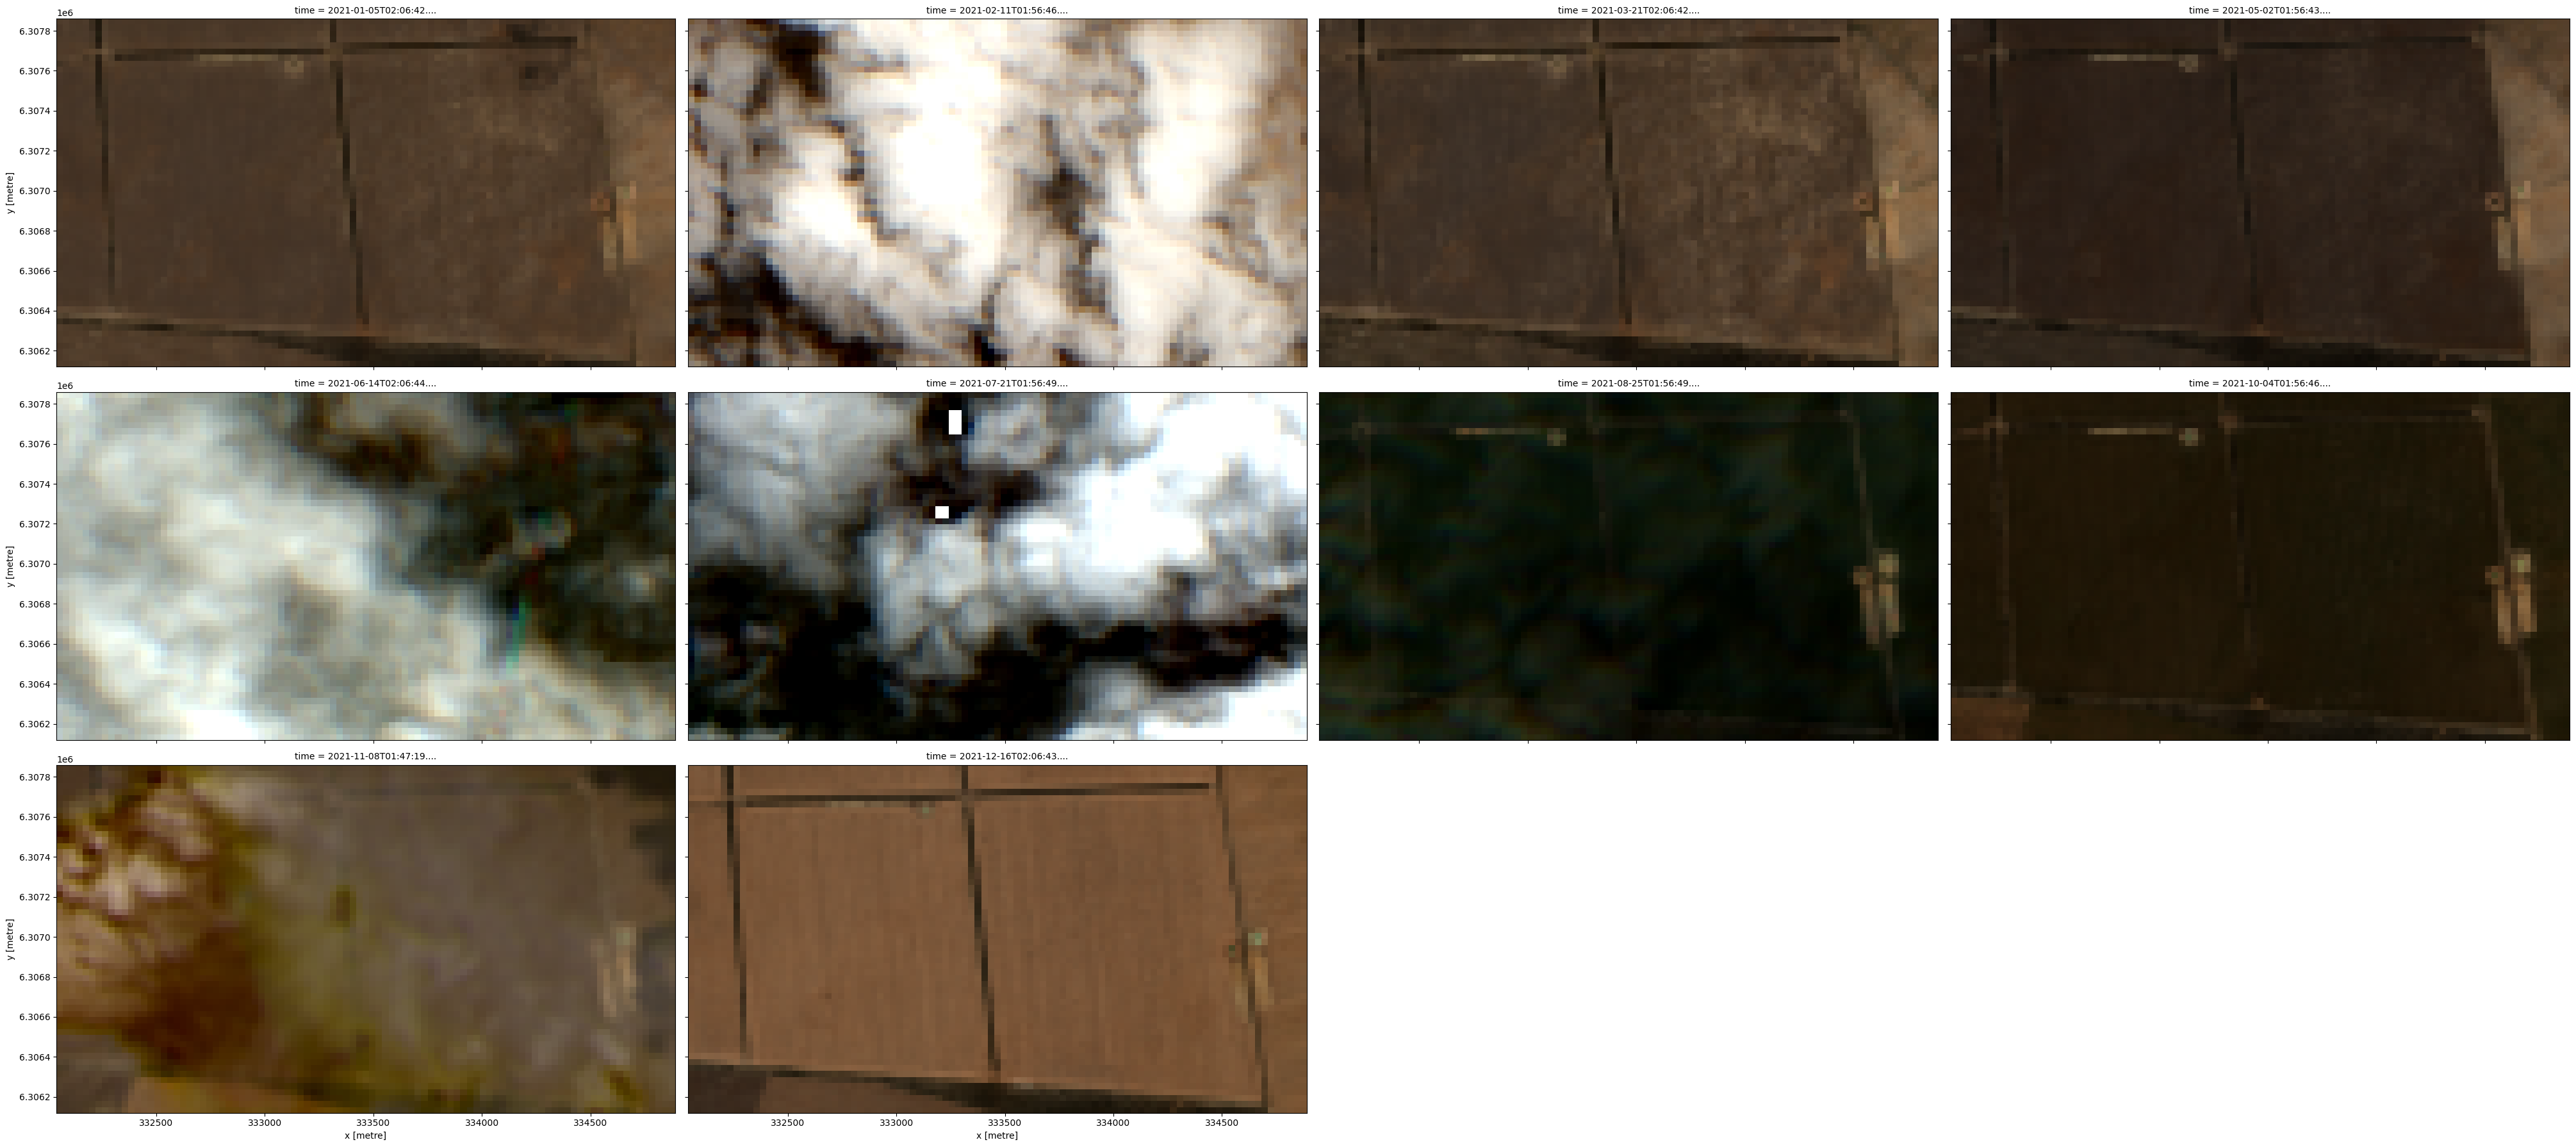

In [19]:
#rgb(ds_mask_scaled_sel,bands=['B04','B03','B02'],index=[1, 85, 90, 121],col_wrap=4)
rgb(ds_mask_scaled_sel,
    bands=['B04','B03','B02'],
    index=list(np.arange(0,len(ds_mask_scaled_sel.time),16)),
    col_wrap=4)



> Visualizing the true color composite over 2 year 



## 4.3. EVI Estimation

Now we can build an Enhanced Vegetation Index (EVI) dataset using the EVI formula:

$\text{EVI} = G \cdot \frac{\text{NIR} - \text{Red}}{\text{NIR} + C_1 \cdot \text{Red} - C_2 \cdot \text{Blue} + L}$

- NIR: Near-Infrared reflectance.
- Red: Reflectance in the red band.
- Blue: Reflectance in the blue band, used primarily to correct for aerosol influences.
- G: Gain factor (often set to 2.5) that scales the index.
- C₁: Coefficient for the aerosol resistance term using the red band (commonly 6).
- C₂: Coefficient for the aerosol resistance term using the blue band (commonly 7.5).
- L: Canopy background adjustment, which helps to minimize soil brightness influences (commonly 1).

We will use the typical values adopted for the MODIS algorithm for G, C1, C2 and L. The output values will range from -1 to 1 and indicate strength of vegetation signal, which correlates with biomass.



In [20]:
# Calculate EVI
evi_ds = 2.5 * ((ds_mask_scaled_sel.NIR - ds_mask_scaled_sel.B04) / (ds_mask_scaled_sel.NIR + 6.0 * ds_mask_scaled_sel.B04 - 7.5 * ds_mask_scaled_sel.B02 + 1.0))
evi_ds = evi_ds.compute()


Plot to demonstrate the images of EVI over time 

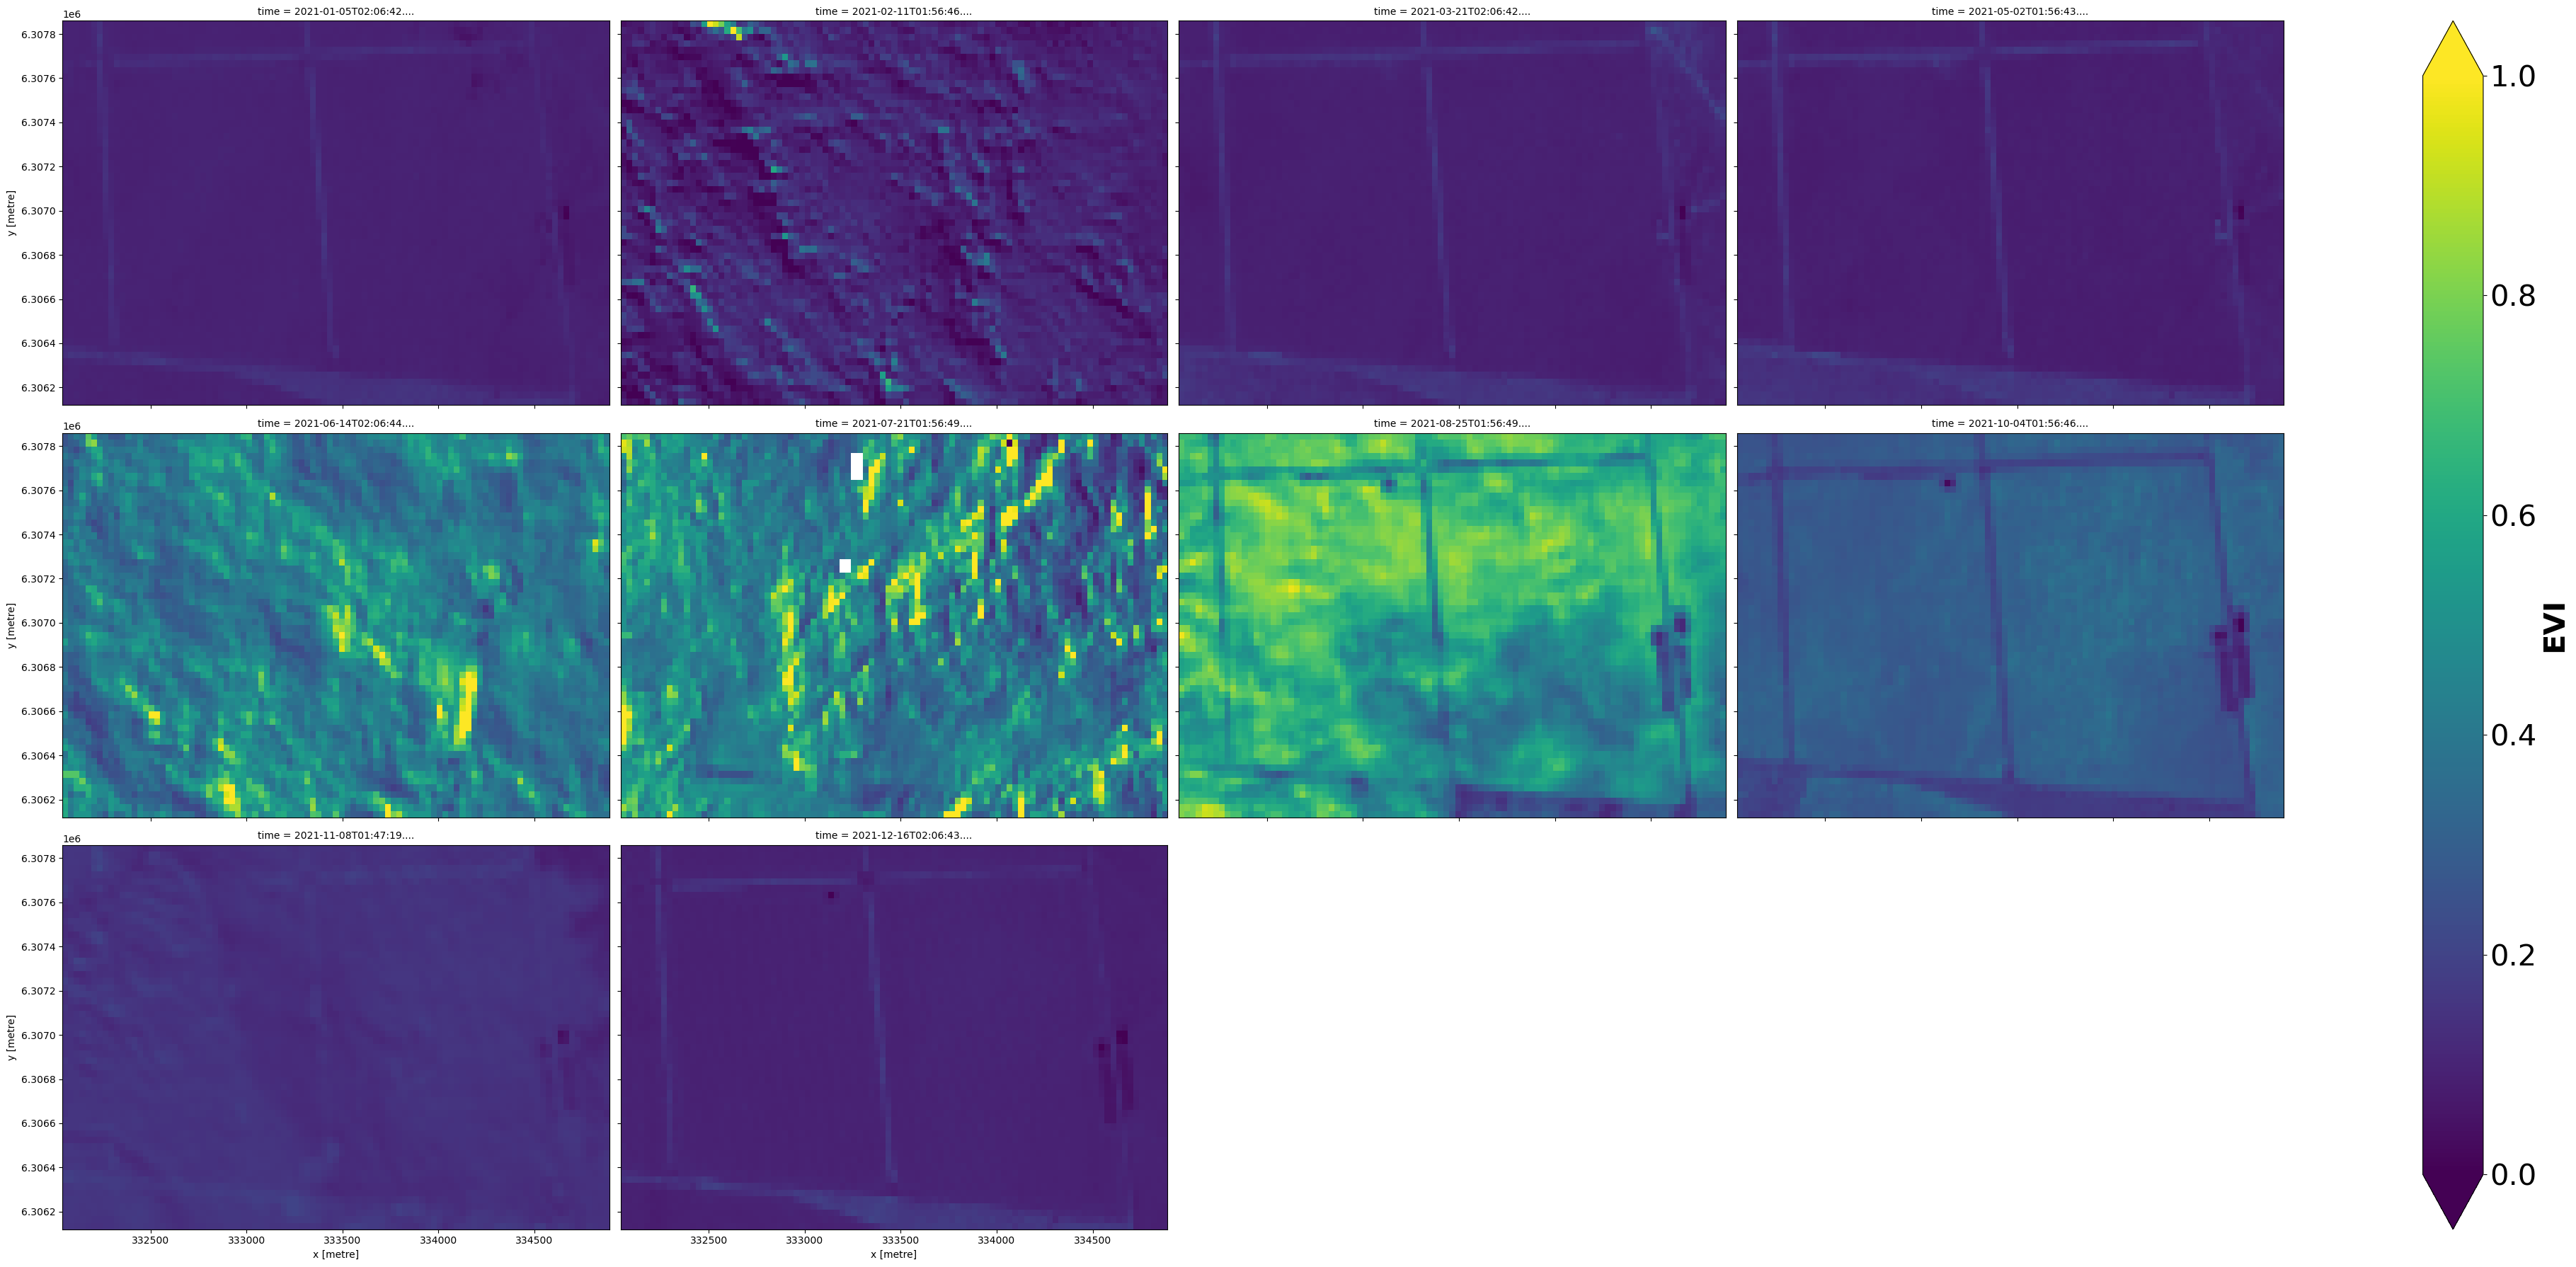

In [53]:
img = single_band(evi_ds,vmin=0,vmax=1,index=list(np.arange(0,len(ds_mask_scaled_sel.time),16)),col_wrap=4,label='EVI')


## 4.4. Quality Filtering

## Link HLS v2 user guide 
For HLS v2.0 products, all quality information is included in the Fmask layer. This layer includes values corresponding to combinations of bits that represent different quality descriptions at each location within the scene. Bits are ordered 76543210 and correspond to the following quality descriptions:

Bit Number|Mask Name|Bit Value|Description
---|:---:|---:|---: 
7-6|Aerosol Level|11,10,01,00|High,Medium,Low,Clear
5|Water|1,0|Yes,No
4|Snow/Ice|1,0|Yes,No
3|Cloud Shadow|1,0|Yes,No
2|Cloud/Shadow Adjacent|1,0|Yes,No
1|Cloud|1,0|Yes,No
0|Cirrus|Reserved|NA

For example, an 8bit integer 224 converted to binary is 11100000. This would indicate high aerosol (bits 7-6), and water (bit 5) are present in a pixel with that value.

Plot the cropped fmask layer to see examples of the quality values in our scene. You can hover the mouse over regions to see the values.




In [22]:
ds_mask_scaled_sel['Fmask'].hvplot.image(x='x',y='y',
                                         groupby=('time'),
                                         cmap='viridis', 
                                         frame_width= 800, 
                                         fontscale=1.6, 
                                         crs='EPSG:32610', 
                                         tiles='ESRI')



:DynamicMap   [time]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (Fmask)

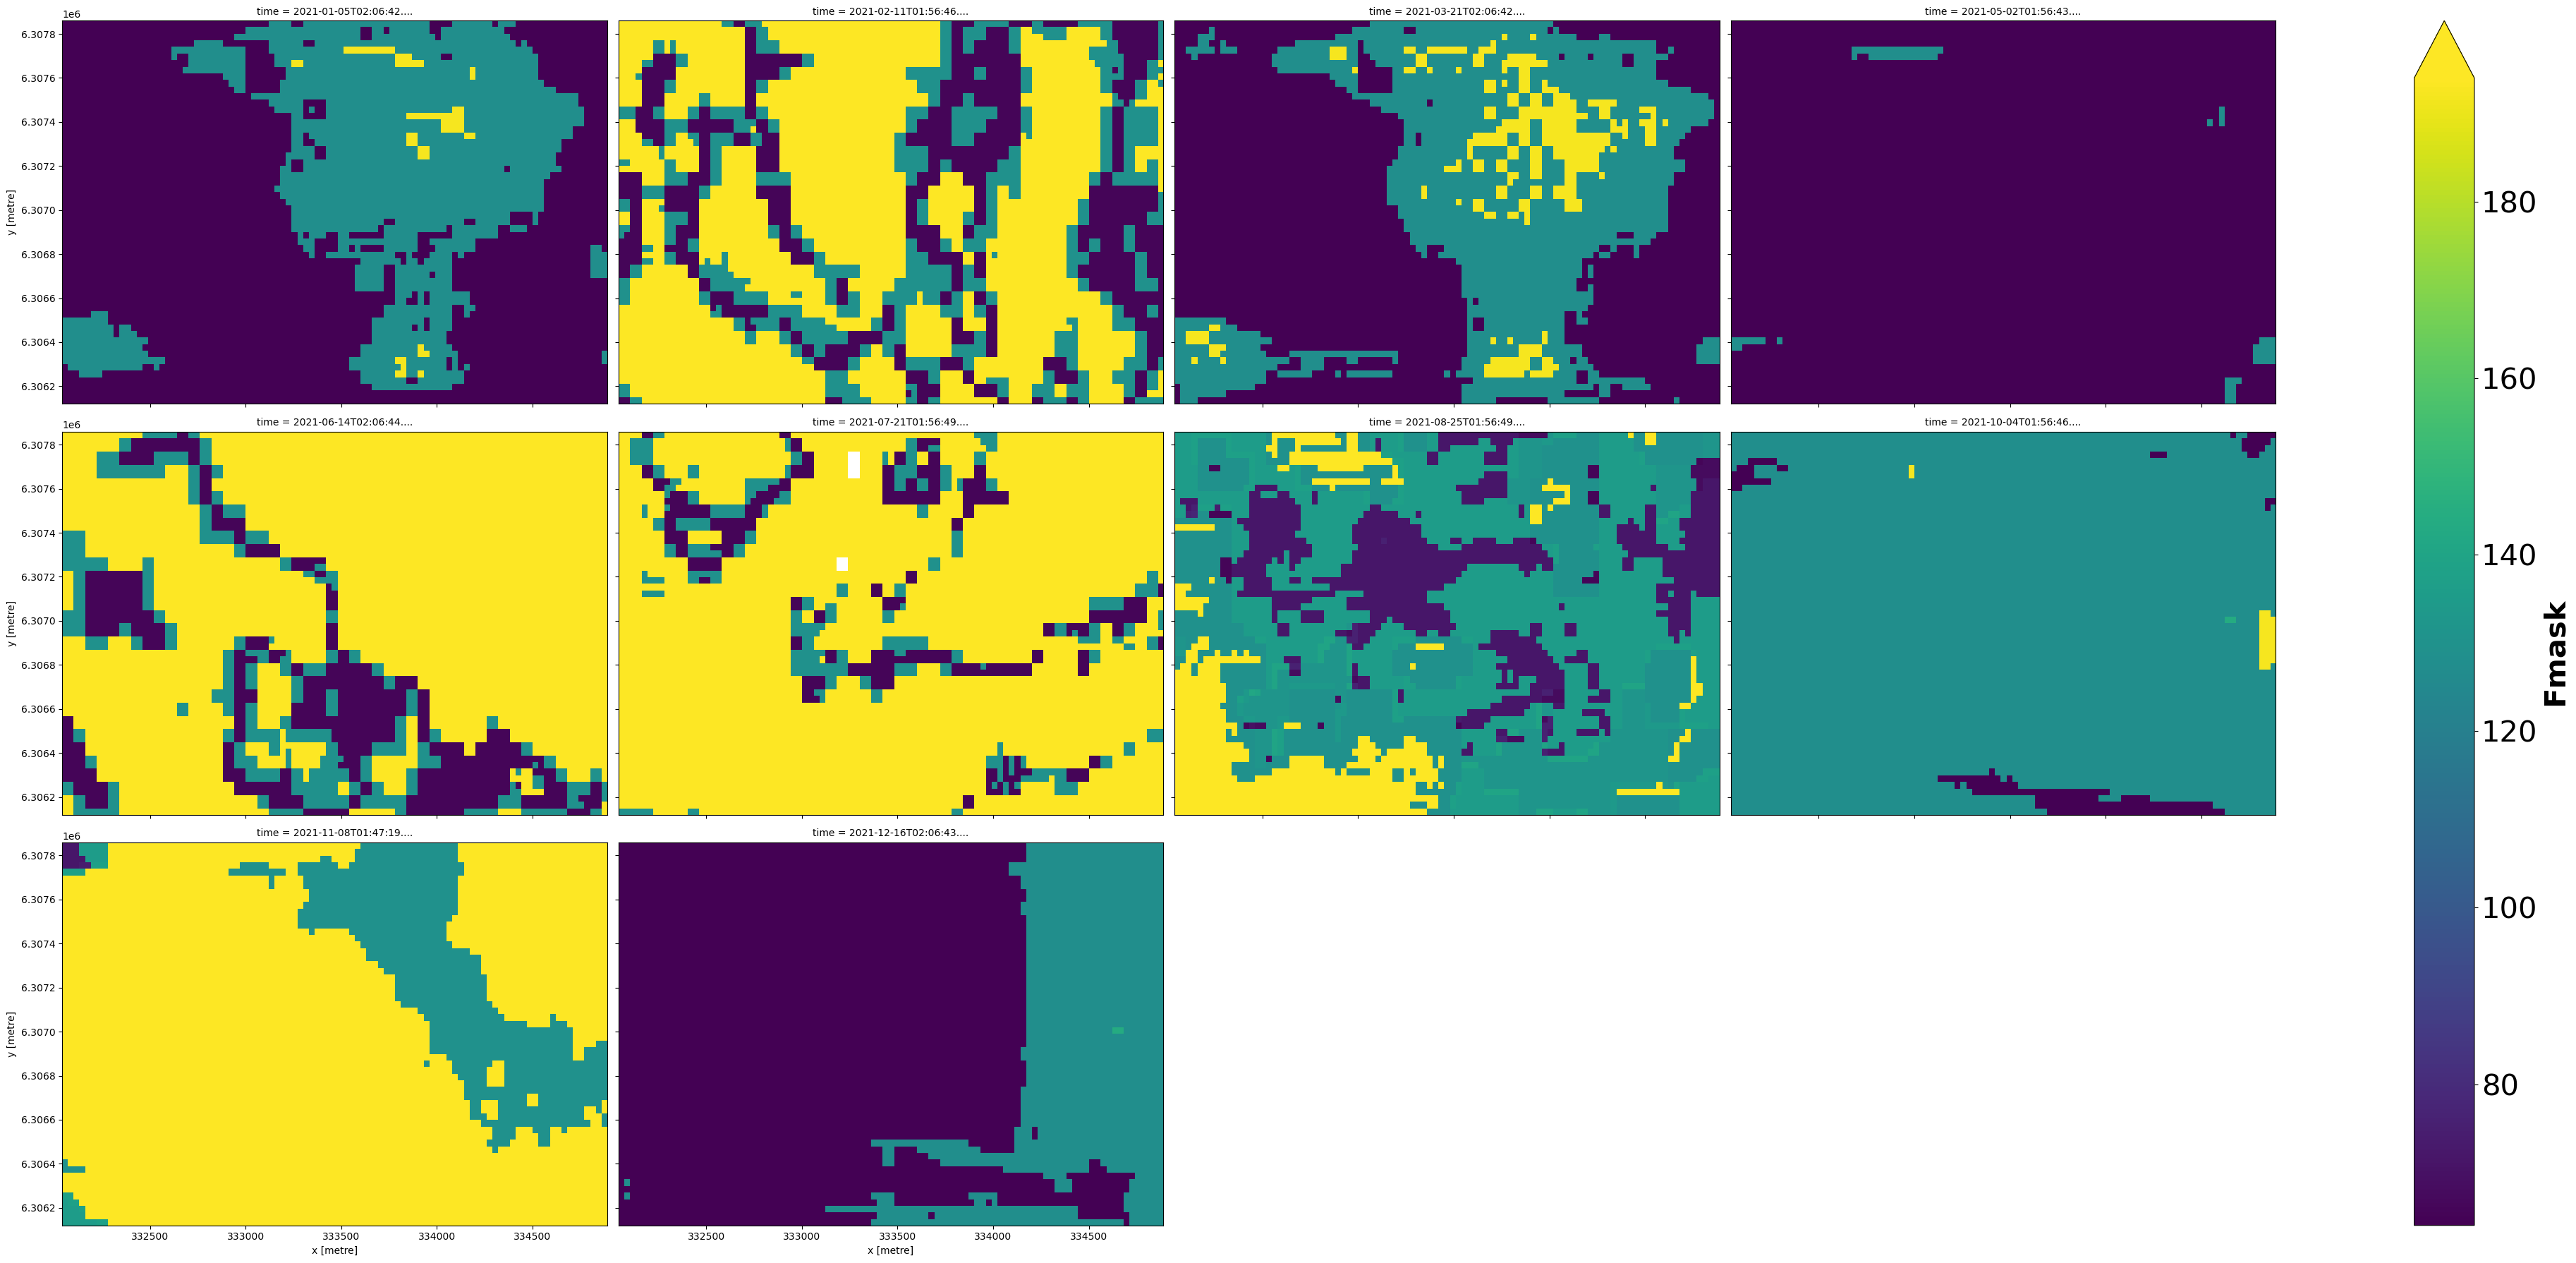

In [55]:
single_band(ds_mask_scaled_sel['Fmask'],index=list(np.arange(0,len(ds_mask_scaled_sel.time),16)),col_wrap=4,label='Fmask')


We can select select the bits we want to mask from our analysis. In this case, we will mask pixels identified as clouds (1), cloud/shadow adjacent (2), cloud shadow (3), snow/ice (4), and water (5). We will ignore the aerosol levels. Create a list of those bit numbers:


Apply the function ```create_quality_mask``` to the data to build a mask, and the use this mask to filter the cropped EVI image

In [57]:
bit_nums = [1,2,3,4,5]
mask_layer = np.stack([create_quality_mask(ds_mask_scaled_sel['Fmask'].sel(time=ds_mask_scaled_sel.time[i]), bit_nums) 
              for i in range(len(ds_mask_scaled_sel.time))])
evi_ds_masked = evi_ds.where(~mask_layer)
mask_array_ds = evi_ds.copy()
mask_array_ds.data = mask_layer

Double check if the mask layer is accurately calculated

In [59]:
mask_array_ds.hvplot.image(x="x", y="y", groupby="time", cmap="Greys_r", crs='EPSG:32610', tiles='ESRI')

:DynamicMap   [time]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (value)

And double check if EVI results have been masked out cloudy pixels

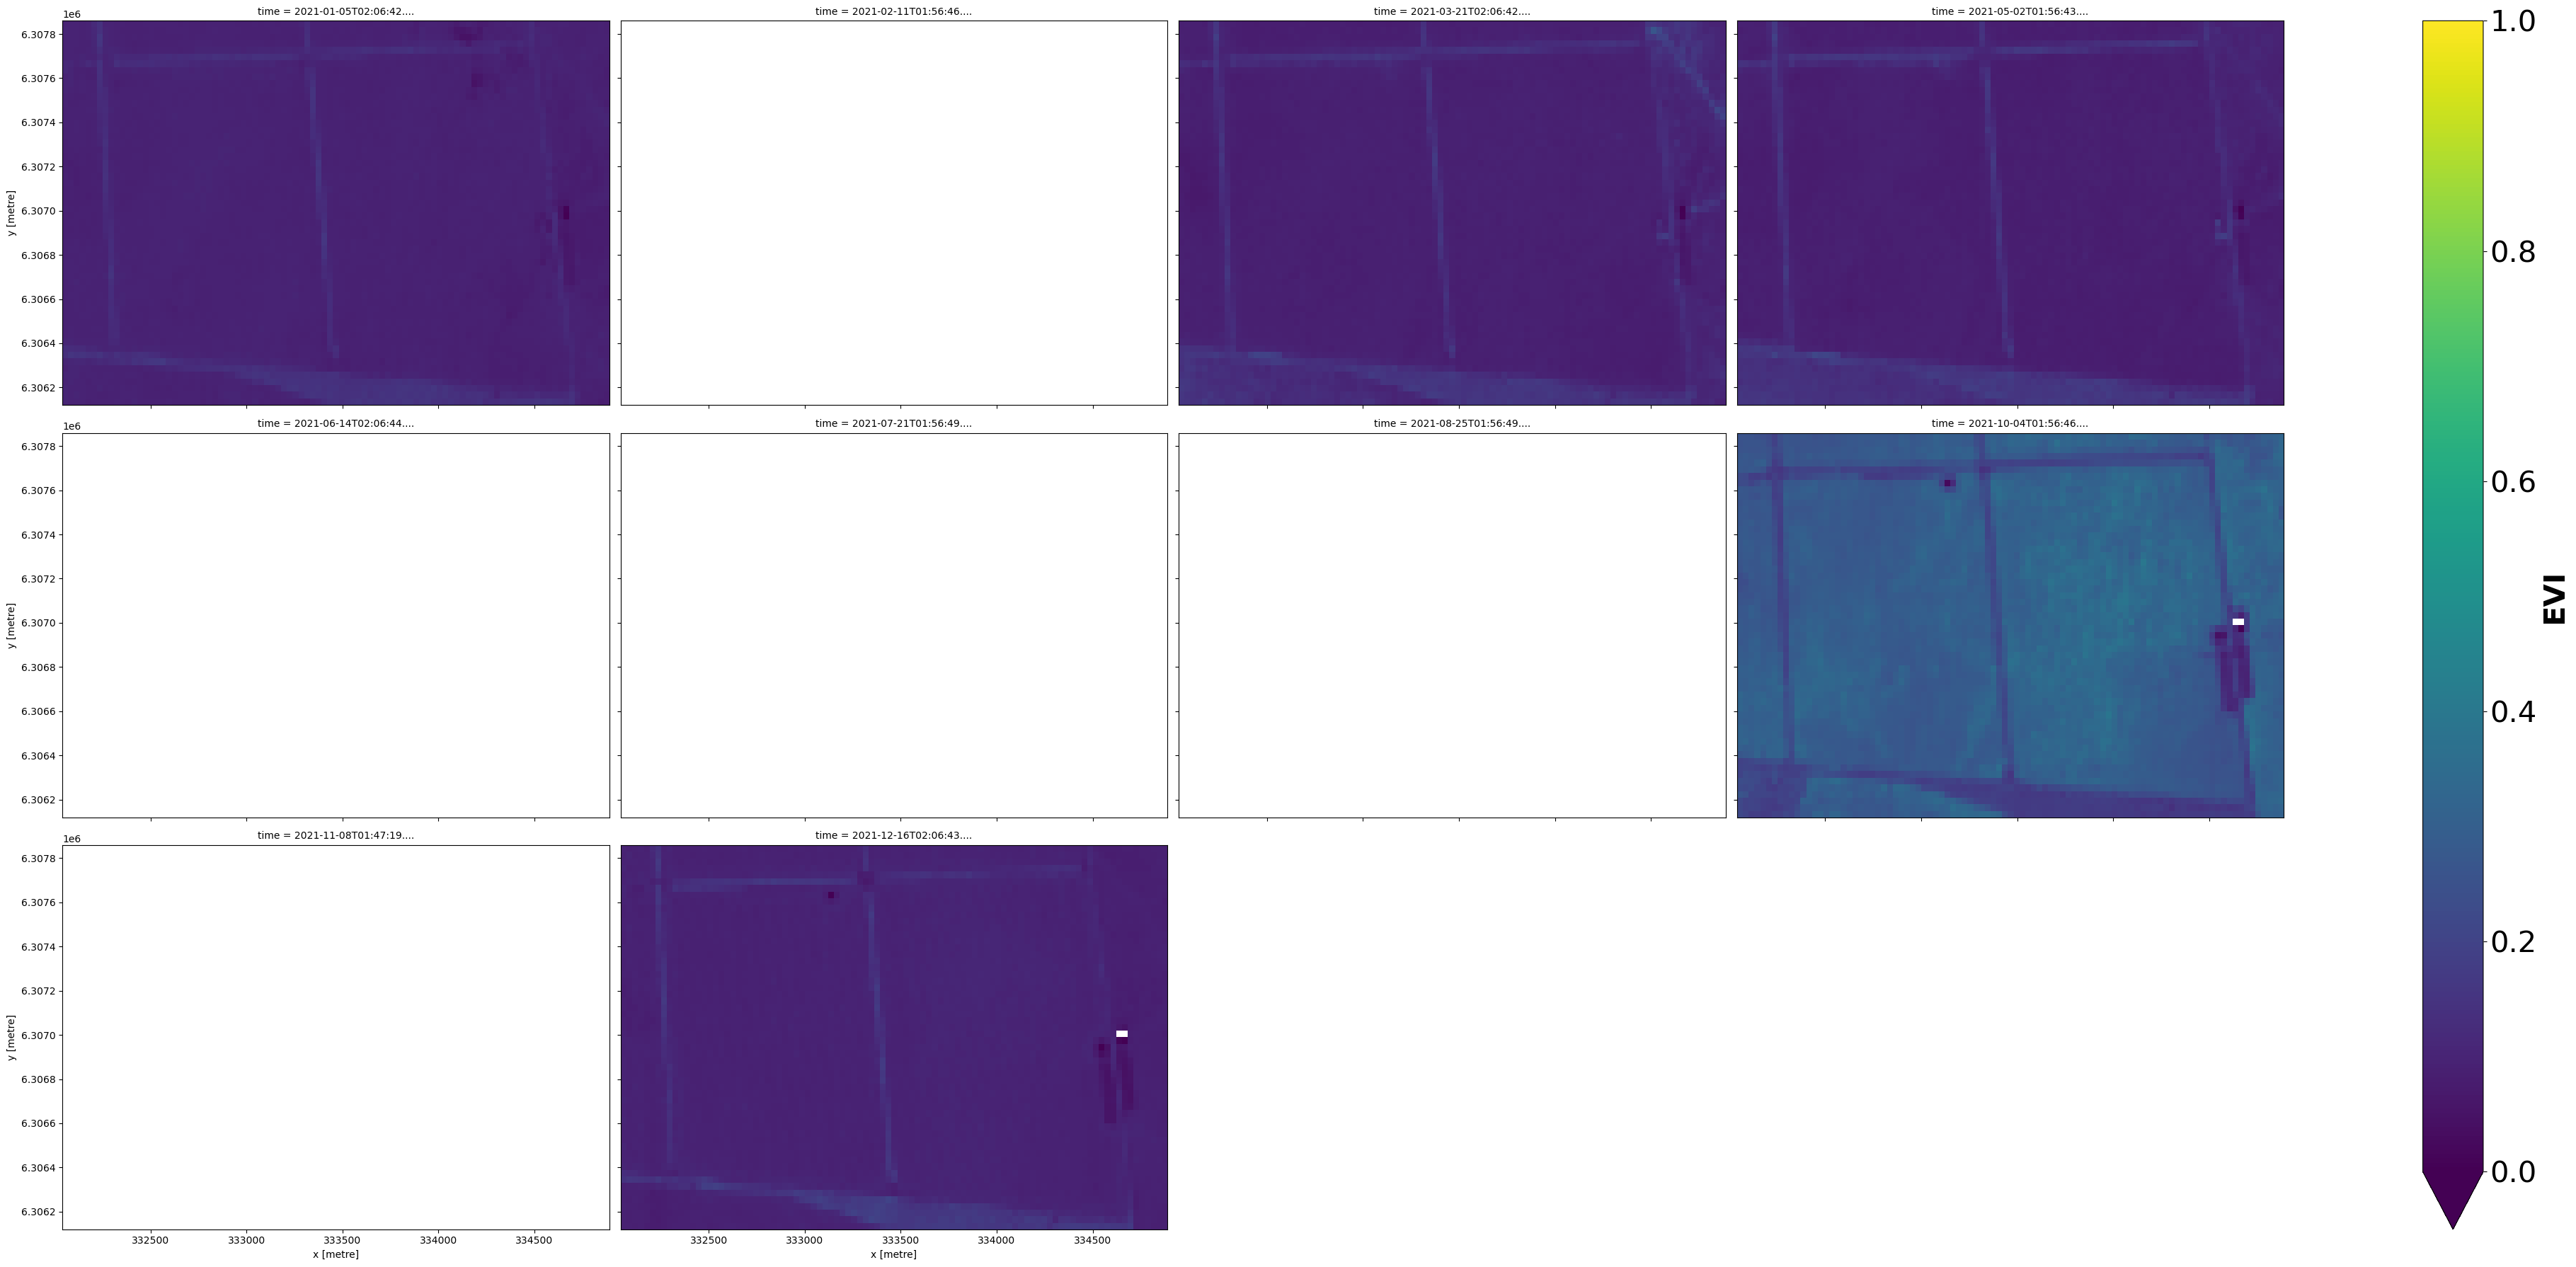

In [60]:
single_band(evi_ds_masked,vmin=0,vmax=1,index=list(np.arange(0,len(ds_mask_scaled_sel.time),16)),col_wrap=4,label='EVI')


As a result, the EVI images have been sucessfully processed using Fmask layer to eliminate cloudy pixels.

## 4.5. Plot the time series of vegetation index

To get an idea of how the vegetation health changes throughout the year(s), we can plot a zonal time series over the region of interest. First we will do a simple plot of the zonal mean of the data.



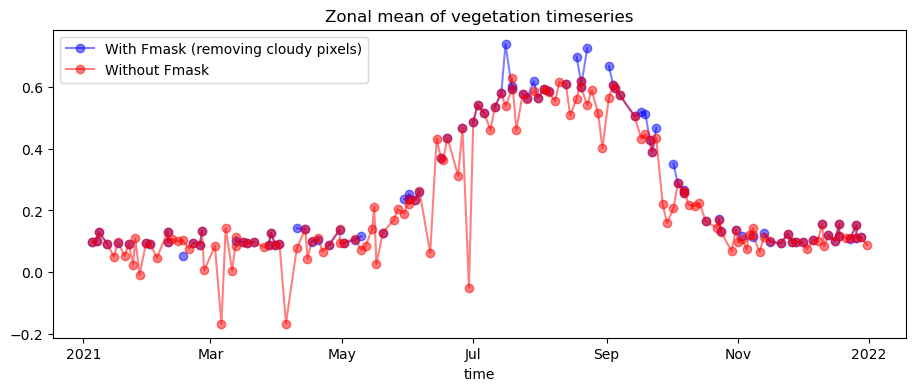

In [62]:
fig, ax = plt.subplots(figsize=(11,4))
evi_ds_masked.mean(['x', 'y']).plot.line('b-o', ax=ax,label='With Fmask (removing cloudy pixels)',alpha=0.5)
evi_ds.mean(['x', 'y']).plot.line('r-o', ax=ax,label='Without Fmask ',alpha=0.5)

plt.title('Zonal mean of vegetation timeseries')
plt.legend()


And also, it will be useful to note on the time series the specific dataset for each time point to demonstrate the advantage of temporal resolution of HLS dataset


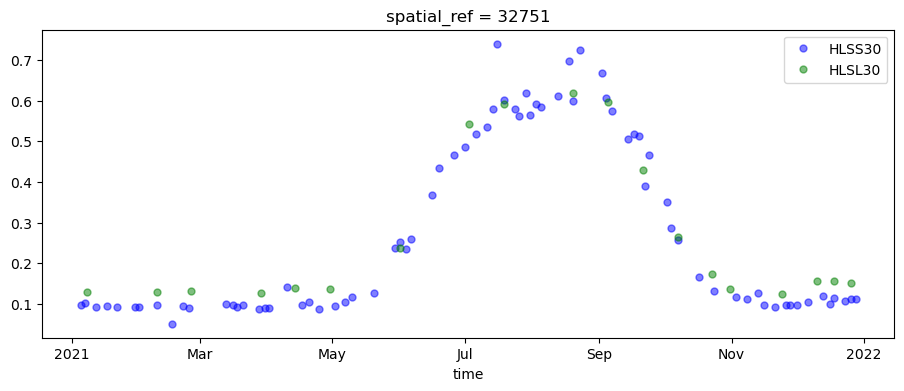

In [63]:
fig, ax = plt.subplots(figsize=(11,4))
time_S30 = [key for key, val in dict_sat_id.items() if val == 'HLS_S30']
time_L30 = [key for key, val in dict_sat_id.items() if val == 'HLS_L30']
evi_ds_masked.mean(['x', 'y']).sel(time=time_S30).plot.line('bo',ax=ax,label='HLSS30',markersize=5,alpha=0.5)
evi_ds_masked.mean(['x', 'y']).sel(time=time_L30).plot.line('go',ax=ax,label='HLSL30',markersize=5,alpha=0.5)
plt.legend()


_______________________________________________________________________________________________________________________________________
# Additional information

**Contact**: Trang Vo (tv0015@uah.edu) - NASA-IMPACT UAH LAS. 

**Last modified**: April 2025